# JPEG

**Groupe** : nicolas.blin, theo.lepage et pierrick.made

Ce notebook est divisé en 3 parties :

1. Implémentations
    - Compression
    - Décompression
    - Tests unitaires
2. Comment fonctionne l'algorithme JPEG ?
3. Utilisation sur un cas concret

In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import unittest
from skimage.transform import resize
from skimage.color import rgb2yuv, yuv2rgb

## Implémentations

### Compression

In [2]:
def tile(matrix, nrows = 8, ncols = 8):
    tile_formation_along_lines = matrix.reshape(matrix.shape[1] // nrows, nrows, -1, ncols)
    tile_formation_along_square = tile_formation_along_lines.swapaxes(1, 2)

    # Put all tiles on first indice, instead of matrix of matrix
    return tile_formation_along_square.reshape(-1, nrows, ncols)

def pad_image(gray_image, to_add_row, to_add_col):
    return np.pad(gray_image, ((0, to_add_col), (0, to_add_row)), mode='symmetric')

def tile_image(image, tile_shape = (8, 8)):
    image_width = image.shape[-1]
    image_height = image.shape[-2]
    to_add_row = 0
    to_add_col = 0

    if image_width % tile_shape[1] != 0:
        to_add_row = tile_shape[1] - image_width % tile_shape[1]
    if image_height % tile_shape[0] != 0:
        to_add_col = tile_shape[0] - image_height % tile_shape[0]

    tiled_padded_gray_image = pad_image(image, to_add_row, to_add_col)
    return tile(tiled_padded_gray_image, *tile_shape)

In [3]:
def dct(block_array):
    block_array -= 128
    dct_on_rows = sc.fft.dct(block_array, 2, axis=0, norm='ortho')
    dct_on_cols = sc.fft.dct(dct_on_rows, 2, axis=1, norm='ortho')
    return dct_on_cols

In [4]:
Q = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72,  92, 95, 98, 112, 100, 103, 99]])

Q_uv = np.array([
    [17, 18, 24, 47, 99, 99, 99, 99],
    [18, 21, 26, 66, 99, 99, 99, 99],
    [24, 26, 56, 99, 99, 99, 99, 99],
    [47, 66, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99]])

def quantification(block_array, q = 50, color_type = "RGB", channel = 0):
    # Select base quantization matrix 
    quantization_matrix = Q
    if color_type == "YUV" and channel != 0:
        quantization_matrix = Q_uv
    
    # Adjust the compression quality
    a = 5000 / q if q < 50 else 200 - 2 * q
    quantization_matrix = (a * quantization_matrix + 50) / 100
    quantization_matrix = np.floor(quantization_matrix)

    return np.round(block_array / quantization_matrix).astype(np.int64)

In [5]:
def zigzag(arr):
    result = np.array([], dtype=np.int64)
    arr_fliplr = np.fliplr(arr)
    arr_flipud = np.flipud(arr)
    for i in range(-arr.shape[0],arr.shape[1]):
        if i % 2 == 0:
            result = np.append(result, arr_fliplr.diagonal(i * -1))
        else:
            result = np.append(result, arr_flipud.diagonal(i * 1))
    return np.trim_zeros(result, trim='b')

In [6]:
huff_DC_table = np.array(['00', '010', '011', '100', '101', '110', '1110', '11110', '111110', '1111110', '11111110', '111111110'])
huff_AC_table = np.array([
    ['00', '01', '100', '1011', '11010', '1111000', '11111000', '1111110110', '1111111110000010', '1111111110000011'],
    ['1100', '11011', '1111001', '111110110', '11111110110', '1111111110000100', '1111111110000101', '1111111110000110', '1111111110000111', '1111111110001000'],
    ['11100', '11111001', '1111110111', '111111110100', '1111111110001001', '1111111110001010', '1111111110001011', '1111111110001100', '1111111110001101', '1111111110001110'],
    ['111010', '111110111', '111111110101', '1111111110001111', '1111111110010000', '1111111110010001', '1111111110010010', '1111111110010011', '1111111110010100', '1111111110010101'],
    ['111011', '1111111000', '1111111110010110', '1111111110010111', '1111111110011000', '1111111110011001', '1111111110011010', '1111111110011011', '1111111110011100', '1111111110011101'],
    ['1111010', '11111110111', '1111111110011110', '1111111110011111', '1111111110100000', '1111111110100001', '1111111110100010', '1111111110100011', '1111111110100100', '1111111110100101'],
    ['1111011', '111111110110', '1111111110100110', '1111111110100111', '1111111110101000', '1111111110101001', '1111111110101010', '1111111110101011', '1111111110101100', '1111111110101101'],
    ['11111010', '111111110111', '1111111110101110', '1111111110101111', '1111111110110000', '1111111110110001', '1111111110110010', '1111111110110011', '1111111110110100', '1111111110110101'],
    ['111111000', '111111111000000', '1111111110110110', '1111111110110111', '1111111110111000', '1111111110111001', '1111111110111010', '1111111110111011', '1111111110111100', '1111111110111101'],
    ['111111001', '1111111110111110', '1111111110111111', '1111111111000000', '1111111111000001', '1111111111000010', '1111111111000011', '1111111111000100', '1111111111000101', '1111111111000110'],
    ['111111010', '', '', '', '', '', '', '', '', '']])
EOB = '1010'

# Help to find the AC/DC Category
def necessary_bits(n):
    bits = 0
    while n:
        bits += 1
        n >>= 1
    return bits

def to_binary(n, nb_bits = 8):
    return bin(n)[2:].zfill(nb_bits)

def huffman(arr):
    # DC (first element)
    if (len(arr) == 0):
        return [f"{huff_DC_table[0]}", EOB]
    e = arr[0]
    cat = necessary_bits(abs(e))
    base_code = huff_DC_table[cat]
    proper_code = to_binary(e if e > 0 else (1 << cat) - 1 + e, cat)
    if e == 0:
        proper_code = ""
    output = [f"{base_code}{proper_code}"]

    # AC (rest of the list)
    run = 0
    for e in arr[1:]:
        if e == 0:
            run += 1
            if run > 9:
                run = 9
        else:
            cat = necessary_bits(abs(e))
            base_code = huff_AC_table[run, cat - 1]
            proper_code = to_binary(e if e > 0 else (1 << cat) - 1 + e, cat)
            output.append(f"{base_code}{proper_code}")
            run = 0

    # EOB
    output.append(EOB)

    return output

In [7]:
def downsampling(channel, coef, color_type, channel_number):
    if color_type == "YUV" and channel_number >= 1:
        if coef == "4:2:2":
            return channel[::, ::2]
        if coef == "4:2:0":
            return channel[::2,::2]
    return channel

In [8]:
def compress(image, q = 50, color_type = "RGB", downsampling_coef = "4:4:4"):
    if len(image.shape) != 3 or image.shape[2] != 3:
        raise Exception('Input image dimension is not supported.')

    image = image.transpose(2, 0, 1)

    res = np.array([])
    for channel_id in range(3):
        channel = downsampling(image[channel_id], downsampling_coef, color_type, channel_id)
        blocs = tile_image(channel)
        for bloc in blocs:
            tmp = dct(bloc)
            tmp = quantification(tmp, q, color_type, channel_id)
            tmp = zigzag(tmp)
            tmp = huffman(tmp)
            res = np.append(res, tmp)

    return ''.join(map(str, res))

In [9]:
def save_jpeg_file(huffman_txt, file_name):
    f = open(file_name, 'w+b')
    i = 0
    byte_arr = []
    while i < len(huffman_txt):
        byte_arr.append(int(huffman_txt[i:i+8],2))
        i += 8
    binary_format = bytearray(byte_arr)
    # add header FIXME
    f.write(binary_format)
    f.close()

### Décompression

In [10]:
def is_in_ac_table(s):
    if s == EOB:
        return 77, 94
    res = np.where(huff_AC_table == s)
    if len(res[0]) == 1:
        return res[0][0], res[1][0] + 1
    return None, None

def is_in_dc_table(s):
    res = np.where(huff_DC_table == s)[0]
    if len(res) == 1:
        return res[0]
    return None

def huff_int_from_bin(bin_str, cat):
    if cat == 0:
        return 0
    i = int(bin_str, 2)
    if i < (1 << (cat - 1)):
        return i - (1 << cat) + 1
    return i

def huffman_inverse(huff_encoded):
    lh, rh = 0, 1
    blocs = []
    while rh < len(huff_encoded):
        bloc = []
        while rh < len(huff_encoded):
            cat = is_in_dc_table(huff_encoded[lh:rh])
            if  cat == None:
                rh += 1
            else:
                bloc.append(huff_int_from_bin(huff_encoded[rh:rh+cat], cat))
                lh = rh + cat
                rh = lh + 1
                break
        while rh < len(huff_encoded):
            run, cat = is_in_ac_table(huff_encoded[lh:rh])
            if  (run, cat) == (None,None):
                rh += 1
            elif (run, cat) == (77,94): # EOB
                lh = rh
                rh += 2
                break
            else:
                for i in range(run):
                    bloc.append(0)
                bloc.append(huff_int_from_bin(huff_encoded[rh:rh+cat], cat))
                lh = rh + cat
                rh = lh + 1
        blocs.append(bloc)
    return blocs

In [11]:
def zigzag_inverse(arr):
    size = 8
    result = np.zeros(size*size).reshape(size, size)
    l_from, l_to = 0, 0
    r, c = 0, 0
    current = 0
    for diag in range(len(arr)):
        if (diag < size): #up-left triangle
            l_from = 0
            l_to = diag
        else: #bot-right triangle
            l_from = diag - size + 1
            l_to = size - 1
        for i in range(l_from, l_to + 1):
            if diag % 2 == 0: #up
                r = l_to - i + l_from
                c = i
            else: #down
                r = i
                c = l_to - i + l_from
            result[r][c] = arr[current]
            current += 1
            if current >= len(arr):
                return result
    return result

In [12]:
def quantification_inverse(block_array, q = 50, color_type = "RGB", channel = 0):
    # Select base quantization matrix 
    quantization_matrix = Q
    if color_type == "YUV" and channel != 0:
        quantization_matrix = Q_uv
    
    # Adjust the compression quality
    a = 5000 / q if q < 50 else 200 - 2 * q
    quantization_matrix = (a * quantization_matrix + 50) / 100
    quantization_matrix = np.floor(quantization_matrix)

    return np.round(block_array * quantization_matrix)

In [13]:
def dct_inverse(block_array):
    dct_on_rows = sc.fft.dct(block_array, 3, axis=0, norm='ortho')
    dct_on_cols = sc.fft.dct(dct_on_rows, 3, axis=1, norm='ortho')
    dct_on_cols += 128
    return np.round(dct_on_cols)

In [14]:
# Matrix : 1 channel of the image
# padded_height : height of the image after padding
# padded_width : width of the image after padding
# nb_rows & nb_cols : bloc size (by default 8,8)
# returned : A matrix of size (padded_height, padded_width) representing the image with all macro blocks merged together
def untile(matrix, padded_height, padded_width, nb_rows = 8, nb_cols = 8):
    res = np.empty([padded_height, padded_width])
    y = -nb_rows
    for x, tile in enumerate(matrix):
        x = x % (padded_width / nb_cols)
        if x == 0: # If x == 0, we are handling a new line to y should be incremented by nb_rows (initilization handled with having y = -nb_rows)
            y += nb_rows
        res[y : y + nb_rows, int(x * nb_cols) : int((x + 1) * nb_cols)] = tile
        
    return res

def unpad_image(padded_image, height, width):
    unpadded_image = np.empty((height, width))
    unpadded_image[0:height, 0:width] = padded_image[0:height, 0:width]
    return unpadded_image

def untile_image(image, padded_height, padded_width, original_height, original_width, padding = (8, 8)):
    return unpad_image(untile(image, padded_height, padded_width, *padding), original_height, original_width)

In [15]:
def padding_to_add(size, bloc_size=8):
    if size % bloc_size != 0:
        return bloc_size - size % bloc_size
    return 0

def decompress(image_compressed, image_shape, q = 50, color_type = "RGB", downsampling_coef = "4:4:4"):
    blocs = huffman_inverse(image_compressed)
    
    # size calculations
    padded_height = image_shape[0] + padding_to_add(image_shape[0])
    padded_width = image_shape[1] + padding_to_add(image_shape[1])
    sampling_image_height = image_shape[0] // (2 if downsampling_coef == "4:4:0" else 1)
    sampling_image_width = image_shape[1] // (1 if downsampling_coef == "4:4:4" else 2)
    sampling_padded_height = sampling_image_height + padding_to_add(sampling_image_height)
    sampling_padded_width = sampling_image_width + padding_to_add(sampling_image_width)
    nb_blocs_in_first_channel = padded_height * padded_width // 64
    nb_blocs_in_other_channels = len(blocs) - nb_blocs_in_first_channel

    res = []
    for bloc_index in range(len(blocs)):
        tmp = zigzag_inverse(blocs[bloc_index])
        tmp = quantification_inverse(tmp, q, color_type, 0 if bloc_index < nb_blocs_in_first_channel else 1)
        tmp = dct_inverse(tmp)
        res.append(tmp)

    res = np.array(res)
    channel_0 = res[:nb_blocs_in_first_channel]
    channel_1 = res[nb_blocs_in_first_channel:(nb_blocs_in_first_channel + nb_blocs_in_other_channels//2)]
    channel_2 = res[(nb_blocs_in_first_channel + nb_blocs_in_other_channels//2):]
    image = []

    for channel in channel_0, channel_1, channel_2:
        if len(channel) != nb_blocs_in_first_channel:
            channel_as_image = untile_image(channel, sampling_padded_height, sampling_padded_width, sampling_image_height, sampling_image_width)
            channel_resized = resize(channel_as_image, (image_shape[0], image_shape[1]))
            image.append(channel_resized)
        else:
            image.append(untile_image(channel, padded_height, padded_width, image_shape[0], image_shape[1]))

    image = np.array(image)
    image = image.transpose(1, 2, 0)

    return image

In [16]:
def read_jpeg_file(file_name):
    # read header FIXME
    data = np.fromfile(file_name, dtype='B')
    return ''.join(map(str,map(to_binary, data)))

### Tests unitaires

In [17]:
class TestTileCompression(unittest.TestCase):
    def test_gray(self):
        gray_result = np.array([[[0, 1],
                            [3, 4]],

                            [[2, 2],
                            [5, 5]],

                            [[6, 7],
                            [6, 7]],

                            [[8, 8],
                            [8, 8]]])
        gray_mat = np.arange(3 * 3).reshape(3, 3)
        self.assertTrue(np.array_equal(gray_result, tile_image(gray_mat, (2, 2))))

class TestTileDecompression(unittest.TestCase):
    def test_gray(self):
        gray_input = np.array([[[0, 1],
                                [3, 4]],

                                [[2, 2],
                                [5, 5]],

                                [[6, 7],
                                [6, 7]],

                                [[8, 8],
                                [8, 8]]])
        gray_result = np.arange(3 * 3).reshape(3, 3)
        self.assertTrue(np.array_equal(gray_result, untile_image(gray_input, 4, 4, 3, 3, (2, 2))))

unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestTileCompression))
unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestTileDecompression))

.
----------------------------------------------------------------------
Ran 1 test in 0.010s

OK
.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [18]:
class TestDCT(unittest.TestCase):
    def test_from_slides(self):
        input_block = np.array([[52, 55, 61, 66, 70, 61, 64, 73],
                                [63, 59, 55, 90, 109, 85, 69, 72],
                                [62, 59, 68, 113, 144, 104, 66, 73],
                                [63, 58, 71, 122, 154, 106, 70, 69],
                                [67, 61, 68, 104, 126, 88, 68, 70],
                                [79, 65, 60, 70, 77, 68, 58, 75],
                                [85, 71, 64, 59, 55, 61, 65, 83],
                                [87, 79, 69, 68, 65, 76, 78, 94]])
        expected_res = np.array([[-415, -30, -61, 27, 56, -20, -2, 0],
                                 [4, -22, -61, 10, 13, -7, -9, 5],
                                 [-47, 7, 77, -25, -29, 10, 5, -6],
                                 [-49, 12, 34, -15, -10, 6, 2, 2],
                                 [12, -7, -13, -4, -2, 2, -3, 3],
                                 [-8, 3, 2, -6, -2, 1, 4, 2],
                                 [-1, 0, 0, -2, -1, -3, 4, -1],
                                 [0, 0, -1, -4, -1, 0, 1, 2]])
        actual = np.round(dct(input_block))
        # np.testing.assert_array_equal(expected_res, actual)
        self.assertTrue(np.array_equal(expected_res, actual))

    def test_from_slides_inverse(self):
        input_block = np.array([[-416, -33, -60, 32, 48, -40, 0, 0],
                                [0, -24, -56, 19, 26, 0, 0, 0],
                                [-42, 13, 80, -24, -40, 0, 0, 0],
                                [-42, 17, 44, -29, 0, 0, 0, 0],
                                [18, 0, 0, 0, 0, 0, 0, 0],
                                [0, 0, 0, 0, 0, 0, 0, 0],
                                [0, 0, 0, 0, 0, 0, 0, 0],
                                [0, 0, 0, 0, 0, 0, 0, 0]])
        expected_res = np.array([[62, 65, 57, 60, 72, 63, 60, 82],
                                 [57, 55, 56, 82, 108, 87, 62, 71],
                                 [58, 50, 60, 111, 148, 114, 67, 65],
                                 [65, 55, 66, 120, 155, 114, 68, 70],
                                 [70, 63, 67, 101, 122, 88, 60, 78],
                                 [71, 71, 64, 70, 80, 62, 56, 81],
                                 [75, 82, 67, 54, 63, 65, 66, 83],
                                 [81, 94, 75, 54, 68, 81, 81, 87]])
        actual = dct_inverse(input_block)
        # np.testing.assert_array_equal(expected_res, actual)
        self.assertTrue(np.array_equal(expected_res, actual))

unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestDCT))

..
----------------------------------------------------------------------
Ran 2 tests in 0.010s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

In [19]:
class TestQuantification(unittest.TestCase):
    def test_from_slides(self):
        input_block = np.array([[-415, -30, -61, 27, 56, -20, -2, 0],
                                [4, -22, -61, 10, 13, -7, -9, 5],
                                [-47, 7, 77, -25, -29, 10, 5, -6],
                                [-49, 12, 34, -15, -10, 6, 2, 2],
                                [12, -7, -13, -4, -2, 2, -3, 3],
                                [-8, 3, 2, -6, -2, 1, 4, 2],
                                [-1, 0, 0, -2, -1, -3, 4, -1],
                                [0, 0, -1, -4, -1, 0, 1, 2]])
        expected_res = np.array([[-26, -3, -6, 2, 2, 0, 0, 0],
                                 [0, -2, -4, 1, 0, 0, 0, 0],
                                 [-3, 1, 5, -1, -1, 0, 0, 0],
                                 [-4, 1, 2, -1, 0, 0, 0, 0],
                                 [1, 0, 0, 0, 0, 0, 0, 0],
                                 [0, 0, 0, 0, 0, 0, 0, 0],
                                 [0, 0, 0, 0, 0, 0, 0, 0],
                                 [0, 0, 0, 0, 0, 0, 0, 0]])
        actual = quantification(input_block, 50, "RGB")
        np.testing.assert_array_equal(expected_res, actual)
        self.assertTrue(np.array_equal(expected_res, actual))

    def test_from_slides_inverse(self):
        input_block = np.array([[-26, -3, -6, 2, 2, -1, 0, 0],
                                [0, -2, -4, 1, 1, 0, 0, 0],
                                [-3, 1, 5, -1, -1, 0, 0, 0],
                                [-3, 1, 2, -1, 0, 0, 0, 0],
                                [1, 0, 0, 0, 0, 0, 0, 0],
                                [0, 0, 0, 0, 0, 0, 0, 0],
                                [0, 0, 0, 0, 0, 0, 0, 0],
                                [0, 0, 0, 0, 0, 0, 0, 0]])
        expected_res = np.array([[-416, -33, -60, 32, 48, -40, 0, 0],
                                 [0, -24, -56, 19, 26, 0, 0, 0],
                                 [-42, 13, 80, -24, -40, 0, 0, 0],
                                 [-42, 17, 44, -29, 0, 0, 0, 0],
                                 [18, 0, 0, 0, 0, 0, 0, 0],
                                 [0, 0, 0, 0, 0, 0, 0, 0],
                                 [0, 0, 0, 0, 0, 0, 0, 0],
                                 [0, 0, 0, 0, 0, 0, 0, 0]])
        actual = quantification_inverse(input_block, 50, "RGB")
        np.testing.assert_array_equal(expected_res, actual)
        self.assertTrue(np.array_equal(expected_res, actual))

unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestQuantification))

..
----------------------------------------------------------------------
Ran 2 tests in 0.002s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

In [20]:
class TestZigZag(unittest.TestCase):

    def test_arange64(self):
        bloc8 = np.arange(64).reshape(8,8)
        ref = np.array([ 0,  1,  8, 16,  9,  2,  3, 10, 17, 24, 32, 25, 18, 11,  4,  5, 12, 19, 26, 33, 40, 48, 41, 34, 27, 20, 13,  6,  7, 14, 21, 28, 35, 42, 49, 56, 57, 50, 43, 36, 29, 22, 15, 23, 30, 37, 44, 51, 58, 59, 52, 45, 38, 31, 39, 46, 53, 60, 61, 54, 47, 55, 62, 63])
        self.assertTrue(np.array_equal(zigzag(bloc8),ref))

    def test_slide_example(self):
        mat = np.array([
            [-26,-3,-6,2,2,-1,0,0],
            [0,-2,-4,1,1,0,0,0],
            [-3,1,5,-1,-1,0,0,0],
            [-3,1,2,-1,0,0,0,0],
            [1,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0]])
        ref = np.array([-26,  -3,   0,  -3,  -2,  -6,   2,  -4,   1,  -3,   1,   1,   5,   1,   2,  -1,   1,  -1,   2,   0,   0,   0,   0,   0,  -1,  -1])
        self.assertTrue(np.array_equal(zigzag(mat),ref))

    def test_compress_decompress(self):
        mat = np.array([
            [-26,-3,-6,2,2,-1,0,0],
            [0,-2,-4,1,1,0,0,0],
            [-3,1,5,-1,-1,0,0,0],
            [-3,1,2,-1,0,0,0,0],
            [1,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0]])
        self.assertTrue(np.array_equal(zigzag_inverse(zigzag(mat)),mat))

    def test_arange64_reverse(self):
        bloc8 = np.arange(64).reshape(8,8)
        self.assertTrue(np.array_equal(zigzag_inverse(zigzag(bloc8)),bloc8))

unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestZigZag))

....
----------------------------------------------------------------------
Ran 4 tests in 0.005s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

In [21]:
class TestHuffMan(unittest.TestCase):

    def test_slide_example(self):
        zigzag_res = np.array([-26,  -3,   0,  -3,  -2,  -6,   2,  -4,   1,  -3,   1,   1,   5,   1,   2,  -1,   1,  -1,   2,   0,   0,   0,   0,   0,  -1,  -1])
        ref = np.array(['11000101', '0100', '1101100', '0101', '100001', '0110', '100011', '001', '0100', '001', '001', '100101', '001', '0110', '000', '001', '000', '0110', '11110100', '000', '1010'])
        self.assertTrue(np.array_equal(huffman(zigzag_res), ref))

    def test_compress_decompress(self):
        zigzag_in = np.array([-26,  -3,   0,  -3,  -2,  -6,   2,  -4,   1,  -3,   1,   1,   5,   1,   2,  -1,   1,  -1,   2,   0,   0,   0,   0,   0,  -1,  -1])
        img_compressed = huffman(zigzag_in)
        img_compressed_str = ''.join(map(str, img_compressed))
        self.assertTrue(np.array_equal(huffman_inverse(img_compressed_str)[0], zigzag_in))


unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestHuffMan))

..
----------------------------------------------------------------------
Ran 2 tests in 0.003s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

In [22]:
class TestZigZagHuff(unittest.TestCase):

    def test_compress_decompress(self):
        mat = np.array([
            [-26,-3,-6,2,2,-1,0,0],
            [0,-2,-4,1,1,0,0,0],
            [-3,1,5,-1,-1,0,0,0],
            [-3,1,2,-1,0,0,0,0],
            [1,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0]])
        compressed = ''.join(map(str, huffman(zigzag(mat))))
        self.assertTrue(np.array_equal(zigzag_inverse(huffman_inverse(compressed)[0]),mat))

    def test_arange64_compress_decompress(self):
        mat = np.arange(64).reshape(8,8)
        compressed = ''.join(map(str, huffman(zigzag(mat))))
        self.assertTrue(np.array_equal(zigzag_inverse(huffman_inverse(compressed)[0]),mat))

unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestZigZagHuff))

..
----------------------------------------------------------------------
Ran 2 tests in 0.010s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

In [23]:
"""
# Performance Testing
import cProfile, pstats, io
pr = cProfile.Profile()
pr.enable()
test_compress_and_decompress()
pr.disable()
s = io.StringIO()
ps = pstats.Stats(pr, stream=s).sort_stats('cumulative')
ps.print_stats(30)
print(s.getvalue())
""" and None

## Comment fonctionne l'algorithme JPEG ?

**JPEG** (Joint Photographic Experts Group) est un ensemble de normes et d'algorithmes de compression d'images.
Le premier standard fut breveté en 1992 mais le groupe est toujours actif et a participé à d'autres projets comme JPEG 2000 ou JPEG XS.
L'algorithme JPEG que nous allons détailler est incontournable et est notamment intégré dans la norme MPEG.

Cet algorithme **compresse avec perte**, c'est à dire qu'il supprime irrémédiablement de l'information dans l'image.
L'image, à la suite d'une compression et d'une décompression, ne sera pas identique à l'image originale.
En effet, les algorithmes de compression sans perte ne sont pas adaptés aux contenus multimédia qui sont constitués de trop nombreuses variations.
Ces dernières sont du bruit qui empêchent d'identifier les redondances et ainsi augmentent la partie non compréssible de l'information.

Les différentes étapes de l'algorithme de compression sont :
1. Séparation en macro-blocs (Block splitting)
2. Application de la transformée en cosinus discrète (Discrete cosine transform)
3. Quantification (Quantization)
4. Linéarisation zigzag et Huffman

Le processus de décompression est exactement l'inverse du schéma de compression.

Pour plus d'informations, vous pouvez vous référer au papier de recherche [The JPEG Still Picture Compression Standard](https://www.ijg.org/files/Wallace.JPEG.pdf).

Les images d'illustration sont issues du cours "Compression de données" de l'EPITA, enseigné par Guillaume Tochon (guillaume.tochon@lrde.epita.fr).

Dans un premier temps, on récupère l'image à traiter sous la forme d'une **matrice 2D** dont chaque valeur représente la luminance (l'intensité) du pixel concerné :
0 représentant le noir et 255 le blanc pour le cas d'une image en niveaux de gris.

Ensuite on va appliquer l'algorithme suivant sur chaque canal de l'image individuellement (1 canal pour une image en niveaux de gris
et 3 canaux pour une image en couleur RGB ou YUV).

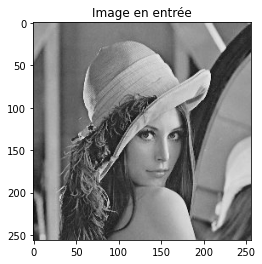

In [24]:
image_example = plt.imread("samples/lena_gray_256.jpg")

def demonstrate_load_image():
    plt.imshow(image_example, cmap='gray')
    plt.title('Image en entrée')
    plt.show()

demonstrate_load_image()

### Étape 1 : Séparation en macro-blocs (tiling)

On va diviser notre image en carrés de taille $8 \times 8$ nommés macro-blocs.
L'objectif de cette opération est de travailler sur des parties de l'image qui n'ont pas de variations trop importantes en niveaux de gris.

**Exemple** : Pour le cas de la photo d'une montagne, le ciel majoritairement bleu sera composé des mêmes niveaux de gris.

L'image pourra ainsi être simplifiée en isolant des blocs de $8 \times 8$ qui seront individuellement peu variant.
En effet, l'objectif de la plupart des algorithmes de compression est d'identifier les redondances dans l'information et de la représenter autrement pour réduire la mémoire utilisée.
La taille de $8 \times 8$ a été choisie car c'est une puissance de 2 (ce qui permet d'accélérer certaines opérations informatiques) et qu'elle est suffisament petite pour ne pas contenir trop de pixels et donc de variations.

Si l'image n'a pas une taille étant un multiple de 8, les derniers blocs à droite et en bas ne seront pas de taille $8$.
On va donc devoir créer des pixels non présent à l'origine afin d'allonger l'image, à la fois en largeur et en longueur si nécessaire.
Pour ce faire, les lignes et colonnes des pixels voisins seront dupliqués par symétrie.

<div style="text-align: center;">
    <img width=40% src="explications/tiling.png">
</div>

Lors de la décompression, le but est de récupérer un à un les macro-blocs et de recomposer l'image.
Pour ce faire les macro-blocs vont être fusionnés le long des lignes et pour chaque colonne.
Il faut ensuite supprimer la bordure artificielle (padding) qui a été ajouter pour avoir une taille étant un multiple de $8$.

#### Implémentation *(`tile_image` et `untile_image`)*

Ce traitement s'effectue sur l'array numpy, de dimension $height \times width$, représentant un canal de l'image.
On effectue un premier `reshape` afin de créer notre structure de tiles : une matrice de tiles, les tiles étant eux-mêmes des matrices, on a bien quatre dimensions.
Cependant, les valeurs au sein des tiles se sont agencées le long des lignes. Par exemple avec une matrice 4x4 et des tiles 2x2 contenant des valeurs de 0 à 15, on aurait dans le premier tile les valeurs de [[0, 1],[2, 3]] alors que nous voulons [[0, 1],[4, 5]].
C'est le rôle du `swapaxes`, ne plus avoir les valeurs le long des lignes mais bien des colonnes. Un dernier `reshape` nous permet simplement de créer un array, de dimension $nb\_blocs \times 8 \times 8$ (plutôt qu'une matrice de matrice).

Le cas des images n'ayant pas une taille multiple de 8 est géré avec la fonction de numpy `pad` qui permet d'ajouter des éléments dans 
un array en réalisant une symétrie. 

Lors de la décompression nous nous contentons de créer un numpy array vide et de le remplir avec nos blocs. Encore une fois, si l'image contenait du padding, on ne conserve que les pixels présents dans l'image originale.

Pour une image de dimension (256, 256), tile_image renvoie un array de dimension (1024, 8, 8).


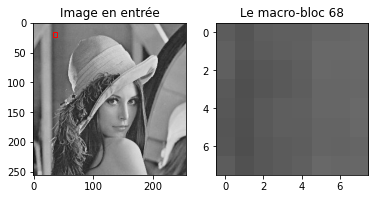

In [25]:
def demonstrate_tile(block_id):
    blocks = tile_image(image_example)
    block = blocks[block_id]

    message = 'Pour une image de dimension {}, tile_image renvoie un array de dimension {}.'
    print(message.format(image_example.shape, blocks.shape))

    pos_x = (block_id * 8) % image_example.shape[1]
    pos_y = 8 * ((block_id * 8) // image_example.shape[0])

    f = plt.figure()

    plot_left = f.add_subplot(1, 2, 1)
    rect = patches.Rectangle((pos_x, pos_y), 8, 8, linewidth=1, edgecolor='r', facecolor='none')
    plot_left.axes.add_patch(rect)
    plt.imshow(image_example, cmap='gray', vmax=255, vmin=0)
    plt.title('Image en entrée')

    plot_right = f.add_subplot(1, 2, 2)
    plt.imshow(block, cmap='gray', vmax=255, vmin=0)
    plt.title('Le macro-bloc ' + str(block_id))

    plt.show()

    return block

# Vous pouvez changer l'ID du block pour adapter les valeurs d'exemple pour les prochaines étapes.
# De cette façon, on observe que les macro-blocs avec peu de variations contiennent peu de valeurs à la dernière étape.

block_id = 68
block_example = demonstrate_tile(block_id)

### Étape 2 : Application de la transformée en cosinus discrète (Discrete cosine transform)

Notre objectif est de réaliser une **analyse de fréquence** sur chaque macro-bloc créé précédemment.
Le problème étant que **la représentation spatiale n'est pas adaptée** car les basses et hautes fréquences sont dispersées partout dans l'image.

#### La représentation spatiale

La représentation spatiale correspond au fait de décomposer une image par toutes les images de base de l'ensemble.
Dans le cas du schéma ci-dessous, on peut représenter la matrice 2D comme la somme de l'intensité de chaque pixel par la matrice élémentaire correspondante *(une matrice remplie de 0 à l'exception d'un 1 à la position du pixel)*.

<div style="text-align: center;">
    <img width=50% src="explications/dct_spatial_representation.png">
</div>

#### Exprimer l'image en termes de fréquences

L'idée est de changer de base pour exprimer l'image en termes de fréquences.
Différentes transformations existent dont :

- Walsh-Hadamard
- Transformation en cosinus discrète (Discrete Fourier transform)
- Transformation de Fourier discrète (Discrete cosine transform)

L'algorithme présenté opte pour la **transformée en cosinus discrète** qui a besoin de moins de coefficients
pour garder l'énergie de l'image que Walsh-Hadamard et qui contrairement à la transformée de Fourier discrète 
ne nécessite pas de stocker des valeurs complexes (ce qui augmenterait la mémoire utilisée).

Il est intéressant de noter que transformée en cosinus discrète est équivalent à la transformée de Fourier discrète de la 
même image que l'on aurait symétrisé.

#### La théorie derrière la transformée en cosinus discrète

Afin d'appliquer la transformée en cosinus discrète, pour une matrice en entrée de taille $N\times N$, nous définissons la matrice $D_N$,
tel que :

$$
\mathbf{D}_N(j, k) = \alpha(j) \cos \left( \frac{\pi (2k + 1) j}{2N} \right) \\
\alpha(j) = \left\{ \begin{array}{ll} \sqrt{\frac{1}{N}} & \mbox{if $j$ = 0} \\ \sqrt{\frac{2}{N}} & \mbox{sinon} \end{array} \right.
$$

Par exemple, pour nos macro-blocs de taille 8x8, cette matrice est donnée ci-dessous.

<div style="text-align: center;">
    <img width=50% src="explications/dct_D8.png">
</div>

Ainsi, nous avons déterminé les 64 fonctions exprimant la base de la transformée en cosinus discrète
ce qui nous permet, en utilisant cette matrice $\mathbf{D}_N$, d'exprimer l'image $I$ dans cette nouvelle base.

$$
J_\mathbf{D} = \mathbf{D}_N I \mathbf{D}_N^\top \\ 
I = \mathbf{D}_N^\top J_\mathbf{D} \mathbf{D}_N
$$

#### Interprétation et utilisation du résultat

$J_\mathbf{D}$ est donc le résultat de la transformation en cosinus discrète de $I$.
Ce traitement nous permet de supprimer une partie de l'information plus simplement et en impactant moins la qualité de l'image 
par rapport à une représentation spatiale.

Le premier coefficient de cette matrice 2D est appelé DC (image de base plate donc continue) et les autres AC (oscillants).
En effet, les premiers coefficients concernent des basses fréquences tandis que les derniers concernent des hautes fréquences.
L'image $I$ est égal à la somme de chaque image de base multiplié par le coefficient correspondant dans $J_\mathbf{D}$.
Il est à noter que plus un coefficient est élevé, plus il sera important pour "reconstruire" fidèlement l'image.
Ainsi, en faisant uniquement la somme de ces coefficients élevés, on peut approcher l'image originale.
Par conséquent, l'objectif de la prochaine étape sera justement d'annuler certains coefficients pour gagner en mémoire utilisée. 

La figure ci-dessous représente les 64 images de base (les matrices élémentaires) de la transformée.
Un pixel blanc correspond à la valeur $\frac{1}{4} \cos(\frac{\pi}{16})$ et un pixel noir à $-\frac{1}{4} \cos(\frac{\pi}{16})$.
L'origine de chaque image est située en haut à gauche.

<div style="text-align: center;">
    <img width=30% src="explications/dct_basis_images.png">
</div>

#### Arrondir pour compresser avec perte

Dans notre cas, le coefficient DC vaut 8 fois la moyenne des valeurs de l'image d'entrée.
Or ces valeurs sont comprises entre 0 et 255 et ont donc statistiquement une moyenne de $128$.
Ainsi pour espérer avoir un coefficient DC petit (qui sera encodé plus tard en moins de bits)
nous enlevons $128$ aux valeurs de $I$ avant d'effectuer la transformation en cosinus discrète.

Il est intéressant de noter que le phénomène de compression avec perte apparaît à cette étape.
En effet les valeurs de $J_\mathbf{D}$ sont **des nombres flottants qui arrondis à l'entier le plus proche 
ne pourront pas être récupérés lors de la décompression**. Ce traitement introduit des erreurs de $1$ en niveau de gris ce 
qui est difficilement visible à l'oeil nu.

#### Implémentation *(`dct` et `dct_inverse`)*

Premièrement, nous soustrayons $128$ à la matrice 2D du macro-bloc.
Pour calculer la transformée en cosinus discrète efficacement nous utilisons la méthode de scipy 
de cette façon : `sc.fft.dct(array, 2, axis=0, norm='ortho')`.

Le deuxième argument précise que nous voulons une DCT de type II, et nous spécifions `norm='ortho'`
pour que les coefficients soient mis à l'échelle par le facteur $\frac{1}{\sqrt{N}}$.
Ensuite, nous effectuons le même appel mais sur l'axe des colonnes (`axis=1`). 

Lors de la décompression nous faisons une DCT de type III et nous ajoutons $128$ à ce résultat.

In [26]:
def demonstrate_dct(block):
    print('Le macro-bloc avant la DCT :')
    print(block)

    block_dct = dct(block)
    print('\nLe macro-bloc après la transformée en cosinus discrète (DCT) :')
    print(block_dct)

    return block_dct

block_example_after_dct = demonstrate_dct(block_example)

# À partir de cette étape, il est plus judicieux de représenter le macro-bloc sous sa forme d'array.
# Bien que le macro-bloc post DCT est différent, il représente toujours l'image mais dans une nouvelle base.

Le macro-bloc avant la DCT :
[[ 92  84  93  95  95 101 101 104]
 [ 96  85  91  94  96 104 104 106]
 [ 95  82  86  89  94 104 103 104]
 [ 90  79  85  89  93 102 102 103]
 [ 87  80  90  94  95 102 102 105]
 [ 85  79  90  94  94 100 100 104]
 [ 86  78  87  91  93 100  99 101]
 [ 92  81  87  91  95 104 102 103]]

Le macro-bloc après la transformée en cosinus discrète (DCT) :
[[ 1.77800000e+03 -5.40317478e+01  5.56532429e+00  1.04559401e+01
   7.25000000e+00  1.17286650e+01  1.47424444e+01 -2.38676662e-01]
 [ 8.42664377e+00  4.00143554e+00  3.95201035e+00  8.41805784e-01
   4.87725805e-02  3.09059206e-01 -1.10782926e-01  2.95602881e-01]
 [ 4.13424425e+00  4.28046667e+00 -5.17766953e-02  1.46984450e-01
   0.00000000e+00 -9.82118698e-02  2.28553391e-01  1.88377305e-02]
 [-6.72777166e-01  1.94358231e-01 -6.33601926e+00 -8.97644615e+00
   1.38892558e-01  8.52310480e-02  5.42958282e-03  1.50464068e-01]
 [ 5.00000000e-01 -3.20364431e-01 -5.57610624e-01 -1.12497028e-01
  -2.50000000e-01  7.5168110

### Étape 3 : Quantification

Cette étape du traitement, réalisée sur chaque macro-bloc, a pour but de réduire à 0 de nombreux coefficients, notamment ceux des hautes fréquences.

L'opération consiste à diviser chaque macro-bloc, post transformation en cosinus discrète, par une **matrice de quantification**.
Les coefficients de cette dernière furent déterminés empiriquement en se referant au ressenti d'un échantillon d'individus.

<div style="text-align: center;">
    <img width=30% src="explications/quantification_Qq.png">
</div>

#### Gestion des couleurs

Dans le cas d'une image RGB, l'opération est identique pour chaque canal.
Cependant, pour une image YUV une matrice de quantification différente sera utilisée pour les deux canaux de la chrominance (U et V).

<div style="text-align: center;">
    <img width=30% src="explications/quantification_Quv.png">
</div>

#### Changer la qualité de la compression

Si on souhaite changer la qualité de la compression, en fonction d'un nombre $q$ compris entre 1 et 100, 
on peut adapter les valeurs de la matrice de quantification en suivant l'algorithme ci-dessous.

<div style="text-align: center;">
    <img width=20% src="explications/quantification_q_algo.png">
</div>

Un nombre $q$ qui tend vers $0$ entraînera une compression importante et donc produira une image occupant peu d'espace mémoire.
Au contraire plus $q$ est grand, plus l'image compressée sera similaire à l'image originale et donc occupera autant de mémoire.  

#### Implémentation *(`quantification` et `quantification_inverse`)*

L'implémentation se fait simplement en appliquant l'algorithme d'adaptation de la matrice de quantification, 
choisie en fonction du canal actuellement traité, en fonction du ratio $q$.
Puis nous effectuons une division entre le résultat de la DCT du macro-bloc et cette matrice de quantification.
Finalement, nous arrondissons chaque nombre flottant à l'entier le plus proche, ce qui introduira une perte d'information.

Lors de la décompression le traitement est similaire car il suffit de remplacer la division par une multiplication.  

In [27]:
def demonstrate_quantification(block):
    print('Le macro-bloc avant la quantification :')
    print(block)

    block_quantification = quantification(block)
    print('\nLe macro-bloc après la quantification :')
    print(block_quantification)

    return block_quantification

block_example_after_quantification = demonstrate_quantification(block_example_after_dct)

# On peut constater que l'ordre de grandeur des coefficients a diminué et certains deviennent même égales à 0.
# Cela nous permettra d'encoder ce macro-bloc avec moins de bits.
# D'ailleurs on peut observer qu'un arrondi a été effectué ce qui engendre une perte d'information comme expliqué ci-dessus.

Le macro-bloc avant la quantification :
[[ 1.77800000e+03 -5.40317478e+01  5.56532429e+00  1.04559401e+01
   7.25000000e+00  1.17286650e+01  1.47424444e+01 -2.38676662e-01]
 [ 8.42664377e+00  4.00143554e+00  3.95201035e+00  8.41805784e-01
   4.87725805e-02  3.09059206e-01 -1.10782926e-01  2.95602881e-01]
 [ 4.13424425e+00  4.28046667e+00 -5.17766953e-02  1.46984450e-01
   0.00000000e+00 -9.82118698e-02  2.28553391e-01  1.88377305e-02]
 [-6.72777166e-01  1.94358231e-01 -6.33601926e+00 -8.97644615e+00
   1.38892558e-01  8.52310480e-02  5.42958282e-03  1.50464068e-01]
 [ 5.00000000e-01 -3.20364431e-01 -5.57610624e-01 -1.12497028e-01
  -2.50000000e-01  7.51681109e-02 -3.96281669e-02  6.37244474e-02]
 [-7.51091227e+00 -1.20133982e-01 -2.09797145e-01  5.12007743e-01
  -2.07867403e-01 -6.42915710e-02 -9.16928510e-02  2.67581535e-01]
 [ 1.81726311e-01  1.73379981e-01  4.78553391e-01  1.72616297e-01
   0.00000000e+00 -2.91468362e-01  3.01776695e-01 -3.44874224e-02]
 [ 1.55762837e-02  2.22379576

### Étape 4 : ZigZag & Huffman

#### ZigZag

Cette étape du traitement est réalisée sur chaque macro-bloc de chaque channel. Elle a pour but de réduire
la quantité de donné nécessaire pour représenter un bloc sans perdre d'information. L'opération consiste à
traverser le bloc en ordre zigzag comme sur les images ci-dessous et s'arrêter quand il n'y a plus que des $0$.

<div style="text-align: center;">
    <img width=50% src="explications/zigzag.png">
</div>

Cette opération est efficace grâce aux étapes précédentes de **dct** et **quantification**. Ces étapes ont permis
de regrouper les coefficients importants dans le coin supérieur gauche du bloc et d'arrondir à $0$ les coefficients
pouvant être négligés. Ainsi, ordonné les éléments du bloc avec l'algorithme zigzag va permettre de placer les
coefficients importants au début et les $0$ à la fin. Ensuite, il suffit de tronquer la liste quand il n'y a plus
de coefficients non nuls. La démonstration ci-dessous montre un exemple dans un cas concret.

##### Implémentation *(`zigzag` et `zigzag_inverse`)*

L'implémentation de `zigzag` se fait grâce aux fonctions de `numpy` : `diagonal()`, `flipud()`, `fliplr()`.
Comme on peut l'observer dans l'image ci-dessus, le bloc est traversé en anti-diagonal en alternant le sens (haut / bas).
Nous utilisons donc les fonctions `fliplr` et `flipud` pour inverser l'ordre du bloc et obtenir les anti-diagonals.
Ensuite, pour changer la direction de l'anti-diagonal, on alterne entre les deux fonctions de flip grâce à un modulo 2.
Finalement, il nous reste plus qu'à enlever les $0$ de la fin grâce à la fonction `np.trim_zeros`.

Pour coder `zigzag_inverse`, on parcourt un bloc en ordre zigzag initialisé avec des $0$. Puis on remplit celui-ci
au fur et à mesure avec la liste reçue en argument. Il suffit donc de s'arrêter quand la liste est vide, notre bloc
est reconstitué. 

In [28]:
def demonstrate_zigzag(block):
    print("Le macro-bloc avant d'utiliser zigzag :")
    print(block)
    zigzag_res = zigzag(block)
    print("La sortie de l'algorithme zigzag:")
    print(zigzag_res)
    print(f"Nous sommes passé de 64 à {len(zigzag_res)} coefficients pour représenter ce bloc.")
    print(f"Cela équivaut à un indice du taux de compression de : {len(zigzag_res)/64}")
    return zigzag_res

block_example_after_zigzag = demonstrate_zigzag(block_example_after_quantification)

# On peut observer que les coefficients importants ont été positioné dans le coin supérieur gauche grâce aux étapes précédentes
# Grace à l'ordre zigzag, on peut donc récupérer ces éléments importants sans stocker tout le bloc.

Le macro-bloc avant d'utiliser zigzag :
[[111  -5   1   1   0   0   0   0]
 [  1   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]]
La sortie de l'algorithme zigzag:
[111  -5   1   0   0   1   1]
Nous sommes passé de 64 à 7 coefficients pour représenter ce bloc.
Cela équivaut à un indice du taux de compression de : 0.109375


#### Huffman

Dans cette partie l'objectif est de réduire la quantité de bits nécessaire pour stocker notre bloc en ordre zigzag.
Cette opération est sans perte d'informations car on peut récupérer exactement le meme bloc en sortie.
Cela ce fait grâce à l'encodage d'Huffman et des tables de conversion prédéterminées (lien ci-dessous).
L'arbre d'Huffman pour ces tables fut généré grâce à des statistiques sur les coefficients et combinaisons les plus fréquents.
Cette opération a pour but d'encoder de manière la plus courte possible les combinaisons de coefficients fréquentes.

Voici la source utilisé pour les tables de conversion : [huffman_tables_for_jpeg_encoding](https://www.globalspec.com/reference/39556/203279/appendix-b-huffman-tables-for-the-dc-and-ac-coefficients-of-the-jpeg-baseline-encoder)


Sur la source précédente on y trouve deux types de tables, **DC** et **AC**. La première, **DC**, est utilisée uniquement
pour le premier coefficient. **AC** est ensuite utilisé pour tous les autres coefs. On y trouve également deux informations
pour obtenir le code binaire correspondant : **RUN** et **CAT**. Le **RUN** est le nombre de zéros qu'il y a avant le coefficient.
**CAT** est la catégorie dans laquelle se trouve le nombre à encoder. Pour trouver celle-ci il suffit de savoir combien de bits
sont nécessaires pour encoder ce nombre.

Finalement, le nombre encodé est l'association entre le `Codeword` trouvé sur ces tables (grâce à run et cat) et le `Code Propre`
qui est calculé en cherchant l'index du nombre dans sa catégorie (ou son encodage binaire signé).

Exemple coef 26 en DC : 26 à besoin de 5 bits pour être écrit en binaire, équivaut à catégorie 5, le Codeword est : 110.
Enfin, 26 en binaire correspond à 11010. Donc L'encodage de 26 sera : 11011010.

##### Implémentation *(`huffman` et `huffman_inverse`)*

Pour implémenter `huffman` il suffit de traiter les coefficients dans l'ordre donnés par la précédente fonction zigzag.
Pour le chacun des coefficients on cherche combien de bits sont nécessaires pour l'encoder en binaire (**CAT**) et le
nombre de zéros le précédent (**RUN**). On trouve le Codeword qui correspond dans les tables. Il nous reste plus qu'à y
ajouter sa représentation en binaire signé.

Pour finir on ajoute l'élément EOB pour signifier que la liste des coefficients pour ce bloc est terminée.

Pour le processus de décompression, `huffman_inverse`, il nous suffit d'avancer dans les nombres binaires jusqu'à tomber
sur un CodeWord présent dans les tables. Ensuite grâce à la catégorie et au run on trouve le coefficient et le nombre de zéros
à insérer. On recommence cette opération jusqu'à tomber sur l'élément EOB qui montre la fin d'un bloc.

In [29]:
def demonstrate_huffman(arr):
    print("La liste avant l'encodage huffman:")
    print(arr)
    block_encoded = huffman(arr)
    print("Le resultat de l'encodage huffman en liste :")
    print(block_encoded)
    block_encoded_str = ''.join(block_encoded)
    print(f"Nous sommes passé de 64 à {len(block_encoded_str)//8} bytes pour représenter ce bloc.")
    print(f"Cela équivaut à un indice du taux de compression de : {len(block_encoded_str)/(64*8)}")

block_example_after_huffman = demonstrate_huffman(block_example_after_zigzag)

La liste avant l'encodage huffman:
[111  -5   1   0   0   1   1]
Le resultat de l'encodage huffman en liste :
['111101101111', '100010', '001', '111001', '001', '1010']
Nous sommes passé de 64 à 4 bytes pour représenter ce bloc.
Cela équivaut à un indice du taux de compression de : 0.06640625


 ## Utilisation sur un cas concret

In [30]:
def compute_rmse(input_image, output_image):
    return np.sqrt(np.mean((input_image - output_image) ** 2))

def compute_snr(input_image, output_image):
    e = input_image - output_image
    return 10 * np.log((input_image ** 2) / (e ** 2))

In [31]:
def demonstrate_compress_and_decompress(input_image, color_type="RGB", q=50, downsampling_coef="4:4:4"):
    input_compressed = compress(input_image, q, color_type, downsampling_coef)
    input_decompressed = decompress(input_compressed, np.shape(input_image), q, color_type, downsampling_coef)

    f = plt.figure()

    plot_left = f.add_subplot(1, 2, 1)
    plt.imshow(input_image / 255)
    plt.title('Image en entrée')

    plot_right = f.add_subplot(1, 2, 2)
    plt.imshow(input_decompressed / 255)
    plt.title('Image décompressée')
    plt.show()

    input_diff = np.absolute(input_image - input_decompressed)/2 + 125
    
    f = plt.figure()
    plot_left = f.add_subplot(1, 2, 1)
    plt.imshow(input_diff / 255)
    plt.title('Error')
    plt.text(input_image.shape[1] + 10, 10, f"RMSE = {compute_rmse(input_image, input_decompressed)}")
    plt.text(input_image.shape[1] + 10, 30, f"Size in kB before encoding = {input_image.shape[0] * input_image.shape[1] / 1000}")
    plt.text(input_image.shape[1] + 10, 40, f"Size in kB after encoding = { len(input_compressed) / 8 / 1000}")
    plt.text(input_image.shape[1] + 10, 50, f"Compression ratio = { (input_image.shape[0] * input_image.shape[1]) / (len(input_compressed) / 8)}")

    plt.show()

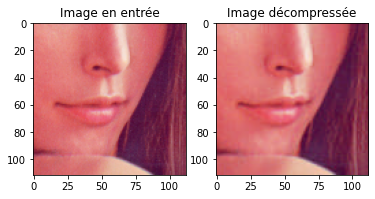

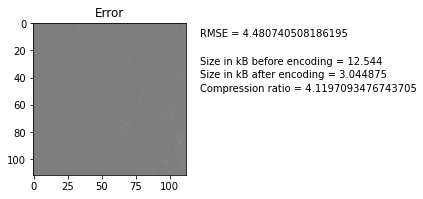

In [32]:
input_image = plt.imread("samples/lena.png") * 255
input_image = input_image[290:402, 250:362]
demonstrate_compress_and_decompress(input_image, color_type="RGB", q=50)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


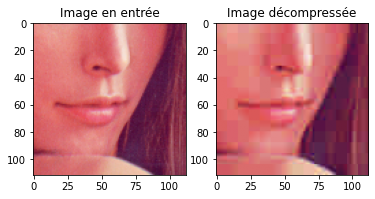

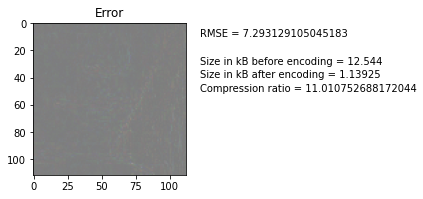

In [33]:
input_image = plt.imread("samples/lena.png") * 255
input_image = input_image[290:402, 250:362]
demonstrate_compress_and_decompress(input_image, color_type="RGB", q=10)

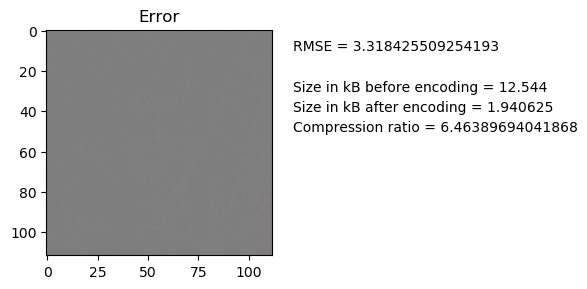

In [0]:
input_image = plt.imread("samples/lena.png") * 255
input_image = input_image[290:402, 250:362]
input_image = rgb2yuv(input_image)
demonstrate_compress_and_decompress(input_image, color_type="YUV", q=50)

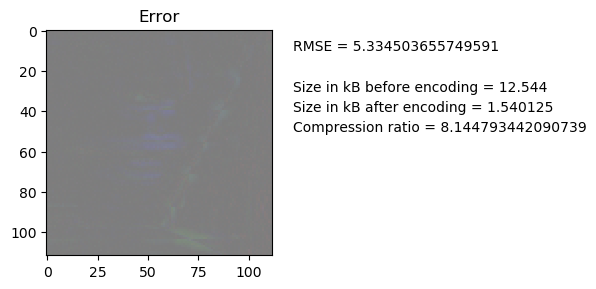

In [0]:
input_image = plt.imread("samples/lena.png") * 255
input_image = input_image[290:402, 250:362]
input_image = rgb2yuv(input_image)
demonstrate_compress_and_decompress(input_image, color_type="YUV", q=50, downsampling_coef="4:2:2")

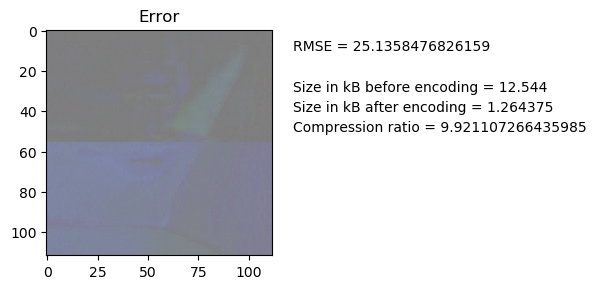

In [0]:
input_image = plt.imread("samples/lena.png") * 255
input_image = input_image[290:402, 250:362]
input_image = rgb2yuv(input_image)
demonstrate_compress_and_decompress(input_image, color_type="YUV", q=50, downsampling_coef="4:2:0")

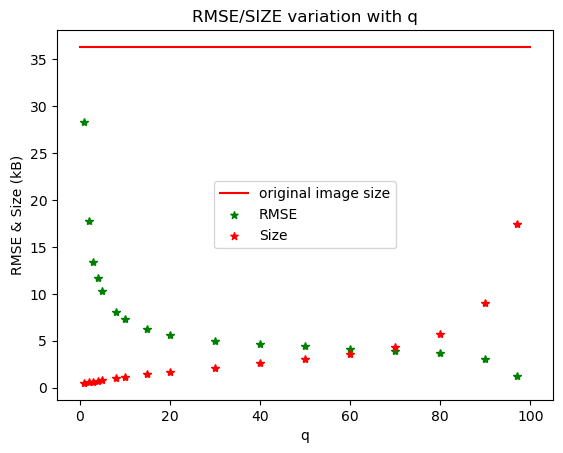

In [0]:
def demonstrate_q_rmse_variation():
    input_image = plt.imread("samples/lena.png") * 255

    input_image = input_image[290:400, 250:360]

    plt.scatter([], [], label= "RMSE", color= "green",  
            marker= "*", s=30)
    plt.scatter([], [], label= "Size", color= "red",  
            marker= "*", s=30)
    original_size = input_image.size / 1000
    plt.plot([0, 100], [original_size, original_size], 'r-',label='original image size')
    plt.xlabel('q')
    plt.ylabel('RMSE & Size (kB)')
    plt.title('RMSE/SIZE variation with q')
    plt.legend()

    for q in [1,2,3,4,5,8,10,15,20,30,40,50,60,70,80,90,97]:
        input_compressed = compress(input_image, q)
        input_decompressed = decompress(input_compressed, np.shape(input_image), q)
        plt.plot(q, compute_rmse(input_image, input_decompressed), "*g")
        plt.plot(q, len(input_compressed)/1000/8, "*r")

    plt.show()

demonstrate_q_rmse_variation()